In [74]:
import numpy as np
from numpy.fft import rfft
from obspy.core import read, Trace, Stream, UTCDateTime
from obspy.signal.invsim import cosine_taper
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline

In [75]:
#data window (seconds), should be a finite fraction of an hour
win = 360 # 0.1 hour
#frequency interval (hertz)
fint = 0.1

In [76]:
datafile = 'NZ.WIZ.10.HHZ.D.2016.118'
st = read(datafile)
st.merge(fill_value = 'interpolate')

1 Trace(s) in Stream:
NZ.WIZ.10.HHZ | 2016-04-27T00:00:00.303127Z - 2016-04-28T00:00:00.753127Z | 100.0 Hz, 8640046 samples

In [77]:
tr = st[0]
#decimate to 50 sps
if (tr.stats.sampling_rate == 100.0):
    tr.decimate(factor=2, strict_length=False)

In [78]:
#set start,end times for the day
year = tr.stats.starttime.year
month = tr.stats.starttime.month
day = tr.stats.starttime.day
start = UTCDateTime(year, month, day, 0, 0, 0)
end = start + 86400

In [79]:
#empty 2d array for spectral amplitudes, required size, filled with zeros
z = np.zeros((249,240))

In [80]:
t = start
#loop through data in 'win' sec blocks

col = 0 #columns of 2d array
while t < end:
    #time as hour fraction
    th = float(t.hour)+ float(t.minute)/60
    #slice win seconds of data
    tr10 = tr.slice(t, t + win)
    tr10.detrend(type='demean')
    npts, nyq = tr10.stats.npts, tr10.stats.sampling_rate/2.0
    #cosine taper
    tap = cosine_taper(npts,0.1)
    #calculate fft
    trf = rfft(tr10.data*tap)
    a = abs(trf[1:])
    #calculate frequencies for fft
    f = np.linspace(0,nyq,npts/2)
    #interpolate to 0.1 Hz (lower resolution)
    df = np.arange(0.1,nyq,0.1) #0.1 Hz frequencies
    da = np.interp(df, f, a)
    #da = np.flip(da, 0) #flip to get low frequencies at 'bottom'
    #fill column with spectral data
    z[:,col] = da
    
    #next window
    col += 1
    t += win

In [81]:
hour = np.arange(0, 24, 0.1)

In [85]:
vmin = 100
vmax = 1e8

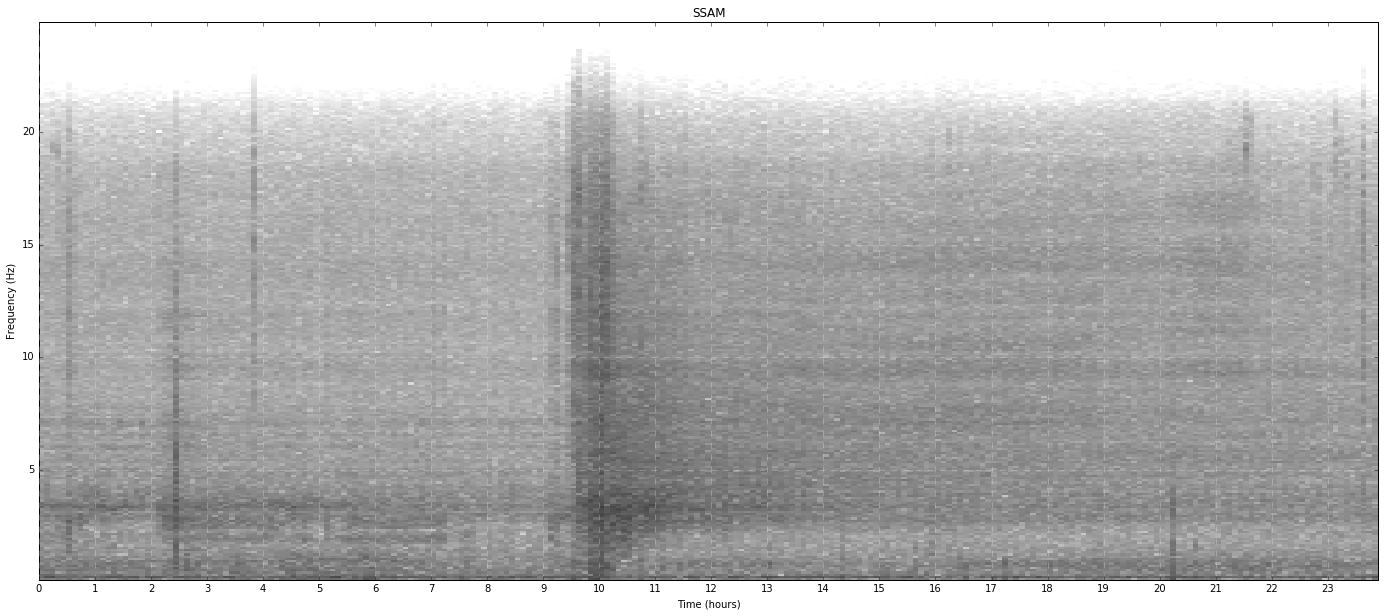

In [89]:
fig,ax = plt.subplots(figsize=(24,10))
ax.pcolormesh(hour, df, z, cmap='binary', norm=matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax))

ax.set_ylim(df.min(), df.max())
ax.set_xlim(hour.min(), hour.max())
ax.set_xticks(np.arange(hour.min(), hour.max(), 1))
ax.set_ylabel('Frequency (Hz)')
ax.set_xlabel('Time (hours)')
ax.grid(b=True, which='major', color='white', linestyle='--', alpha=0.5)
plt.title('SSAM')

#plt.savefig('temaari_2012_krvz.png', dpi=200)

In [84]:
print z.min(), z.max()

0.00419940468337 3174088.78854
